In [5]:
import numpy as np
import json
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import cv2
import shutil
from tqdm import tqdm, trange
import scipy.ndimage as ndimage
import pickle
import SimpleITK as sitk
import h5py

# filename = "/storage/valis_reg/segmentation_masks/1202_msrcr_Simple Segmentation.h5"

def read_h5_mask(filename):
    with h5py.File(filename, "r") as f:
        data = f['exported_data']
        data = np.squeeze(np.array(data), axis=-1)
    return data


# mask = read_h5_mask(filename)
regex = re.compile(r'\d+')


def black2white(img):
    img = img.copy()
    img[img == [0,0,0]] = 255
    return img


In [60]:
retinex_imgs = [imageio.imread(f'rf_trained_pred/retinex/{img}') for img in tqdm(sorted(os.listdir('rf_trained_pred/retinex/'))) if regex.match(img)[0] not in ['0849','2089','1450']]
retinex_masks = [cv2.imread(f'rf_trained_pred/processed_mask/{img}', cv2.IMREAD_GRAYSCALE) for img in tqdm(sorted(os.listdir('rf_trained_pred/processed_mask/'))) if regex.match(img)[0] not in ['0849','2089','1450']]

def binarize_mask(mask):
    mask[mask>0] = 1
    return mask

retinex_masks = [binarize_mask(mask) for mask in tqdm(retinex_masks)]

100%|██████████| 2624/2624 [00:01<00:00, 1374.21it/s]


In [66]:
orig_imgs = [imageio.imread(f'rf_trained_pred/original/{img}') for img in tqdm(sorted(os.listdir('rf_trained_pred/original/'))) if regex.match(img)[0] not in ['0849','2089','1450']]

100%|██████████| 2627/2627 [01:28<00:00, 29.73it/s]


In [67]:
def find_largest_image_dimensions(retinex_imgs):
    largest_r = 0
    largest_c = 0
    for img in retinex_imgs:
        r, c = img.shape[0], img.shape[1]
        if r > largest_r:
            largest_r = r
        if c > largest_c:
            largest_c = c
    return largest_r,largest_c

largest_r, largest_c = find_largest_image_dimensions(retinex_imgs=retinex_imgs)


def pad_img_gray(img, r, c):
    padded_img = np.ones((r, c))*255
    padded_img[:img.shape[0], :img.shape[1]] = img
    return padded_img

def pad_mask(mask, r, c):
    padded_mask = np.zeros((r, c))
    padded_mask[:mask.shape[0], :mask.shape[1]] = mask
    return padded_mask

def pad_img_color(img, r, c):
    padded_img = np.ones((r, c, 3))*255
    padded_img[:img.shape[0], :img.shape[1], :] = img
    return padded_img

def pad_img(img, r, c, mask=False):
    if mask:
        return pad_mask(img, r, c)
    if len(img.shape) == 2:
        return pad_img_gray(img, r, c)
    else:
        return pad_img_color(img, r, c)


retinex_imgs = [pad_img(img, largest_r, largest_c) for img in tqdm(retinex_imgs)]
orig_imgs = [pad_img(img, largest_r, largest_c) for img in tqdm(orig_imgs)]
retinex_masks = [pad_img(mask, largest_r, largest_c, mask=True) for mask in tqdm(retinex_masks)]

100%|██████████| 2624/2624 [00:48<00:00, 53.76it/s]


In [47]:
with open('/storage/valis_reg/sitk_combined_213/transforms.pkl', 'rb') as file:
    transforms = pickle.load(file)

def apply_channel_transform(img_channel, transform):
    sitk_img = sitk.GetImageFromArray(img_channel)
    moved_img = sitk.Resample(sitk_img, transform, sitk.sitkLinear, 255.0, sitk_img.GetPixelID())
    moved_img = sitk.GetArrayFromImage(moved_img)
    return moved_img.astype(np.uint8)

def apply_transform(img, transform):
    r = apply_channel_transform(img[:,:,0], transform)
    g = apply_channel_transform(img[:,:,1], transform)
    b = apply_channel_transform(img[:,:,2], transform)
    return np.stack([r,g,b], axis=2)

def apply_transfrom_mask(mask, transform):
    sitk_img = sitk.GetImageFromArray(mask)
    moved_img = sitk.Resample(sitk_img, transform, sitk.sitkNearestNeighbor, 0.0, sitk_img.GetPixelID())
    moved_img = sitk.GetArrayFromImage(moved_img)
    return moved_img.astype(np.uint8)

In [44]:
assert len(retinex_imgs) == len(transforms)

In [68]:
retinex_imgs_aligned = [apply_transform(img, transform) for img, transform in tqdm(zip(retinex_imgs, transforms))]
orig_imgs_aligned = [apply_transform(img, transform) for img, transform in tqdm(zip(orig_imgs, transforms))]

2624it [06:06,  7.17it/s]


In [62]:
retinex_masks_aligned = [apply_transfrom_mask(mask, transform) for mask, transform in tqdm(zip(retinex_masks, transforms))]

2624it [01:13, 35.53it/s]


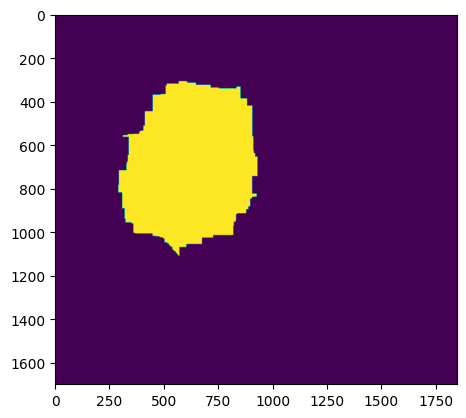

In [65]:
plt.imshow(retinex_masks_aligned[4])

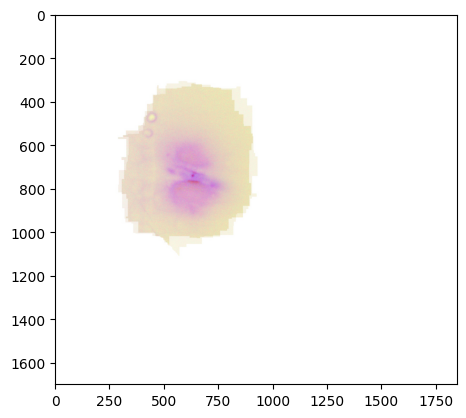

In [43]:
# Overlay two images and plot them

def overlay_images(img1, img2, alpha=0.4):
    return cv2.addWeighted(img1.astype(np.uint8), alpha, img2.astype(np.uint8), 1-alpha, 0)

plt.imshow(overlay_images(moved_img, retinex_imgs[2]))

## Saving all Aligned Images to 213_BFIW_aligned

In [69]:
os.makedirs('213_BFIW_aligned/retinex', exist_ok=True)
os.makedirs('213_BFIW_aligned/original', exist_ok=True)
os.makedirs('213_BFIW_aligned/mask', exist_ok=True)

for i, (retinex_img, orig_img, mask) in tqdm(enumerate(zip(retinex_imgs_aligned, orig_imgs_aligned, retinex_masks_aligned))):
    imageio.imwrite(f'213_BFIW_aligned/retinex/{str(i).zfill(4)}.jpg', retinex_img)
    imageio.imwrite(f'213_BFIW_aligned/original/{str(i).zfill(4)}.jpg', orig_img)
    imageio.imwrite(f'213_BFIW_aligned/mask/{str(i).zfill(4)}.jpg', mask)

2624it [01:47, 24.47it/s]
